<a href="https://colab.research.google.com/github/adityaraghavan98/IQ-X/blob/main/IQ_X_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IQ-X: Image Quality Assessment via Cross-Modal Validation

- Chiranjib Chakrabarti (
chiranjib.chakrabarti@ucd.ie)
- Aditya Raghavan(araghav4@vols.utk.edu)




**IQ-X** is a reference-based, physics-informed framework for assessing **AFM image quality** using **SEM as a stability baseline**.

### Core idea
AFM image degradation can arise from probe convolution, feedback artifacts, or scan instabilities, but standard metrics often conflate these effects with true sample morphology. IQ-X resolves this ambiguity by comparing **temporal stability of image metrics** across AFM and SEM images acquired from the same region.

> If a metric evolves in AFM but remains stable in SEM, it reflects **AFM image quality**, not sample changes.

### How to read this notebook
1. We introduce the motivation and assumptions behind IQ-X.
2. We define physically interpretable image quality metrics.
3. We validate metrics using SEM stability.
4. We diagnose the dominant AFM degradation mechanism.

This notebook is intended to be **self-contained and interpretable**, without relying on machine learning or ground-truth tip information.

## Motivation

Atomic Force Microscopy (AFM) image quality often degrades during extended measurements due to tip wear, contamination, or scan-related artifacts. However, diagnosing the *cause* of degradation is difficult because common image metrics—such as roughness—conflate instrument effects with intrinsic sample morphology.

This ambiguity leads to two key challenges:
- Apparent changes in AFM images may reflect **instrument artifacts rather than true sample evolution**.
- Manual, qualitative inspection is often required, limiting automation and reproducibility.

IQ-X addresses this problem by introducing a **cross-modal validation strategy**, using SEM images as a non-contact reference to distinguish AFM-specific image degradation from sample-dependent features.


## Conceptual Overview of IQ-X

IQ-X is built on a simple but powerful principle:

> **SEM images provide a stable, non-contact reference for evaluating AFM image quality.**

Since SEM imaging does not involve a physical probe interacting with the surface, temporal stability of image metrics in SEM implies that those metrics are dominated by **sample morphology**, not instrument effects.

Conversely, image metrics that:
- remain stable in SEM, but
- evolve systematically in AFM

are interpreted as indicators of **AFM image quality degradation**.

This reference-based validation step is the key distinguishing feature of the IQ-X framework.


In [1]:
!gdown --fuzzy https://drive.google.com/file/d/11QjownVQ-8HTjM858d63f6aQXQ95Bsgb/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1laKt1jPjLQsfAewS-L_gNExczSkLP5wt/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=11QjownVQ-8HTjM858d63f6aQXQ95Bsgb
To: /content/reordered_afm_array.npy
100% 30.7M/30.7M [00:00<00:00, 89.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1laKt1jPjLQsfAewS-L_gNExczSkLP5wt
From (redirected): https://drive.google.com/uc?id=1laKt1jPjLQsfAewS-L_gNExczSkLP5wt&confirm=t&uuid=3fdde4bd-9bde-40b2-bfe2-5a3020e5e6f7
To: /content/reordered_cropped_sem_array.npy
100% 152M/152M [00:01<00:00, 145MB/s]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import fft2, fftshift
from scipy.interpolate import interp1d


In [6]:
import numpy as np

reordered_afm_array = np.load('/content/reordered_afm_array.npy', allow_pickle=True)
reordered_cropped_sem_array = np.load('/content/reordered_cropped_sem_array.npy', allow_pickle=True)

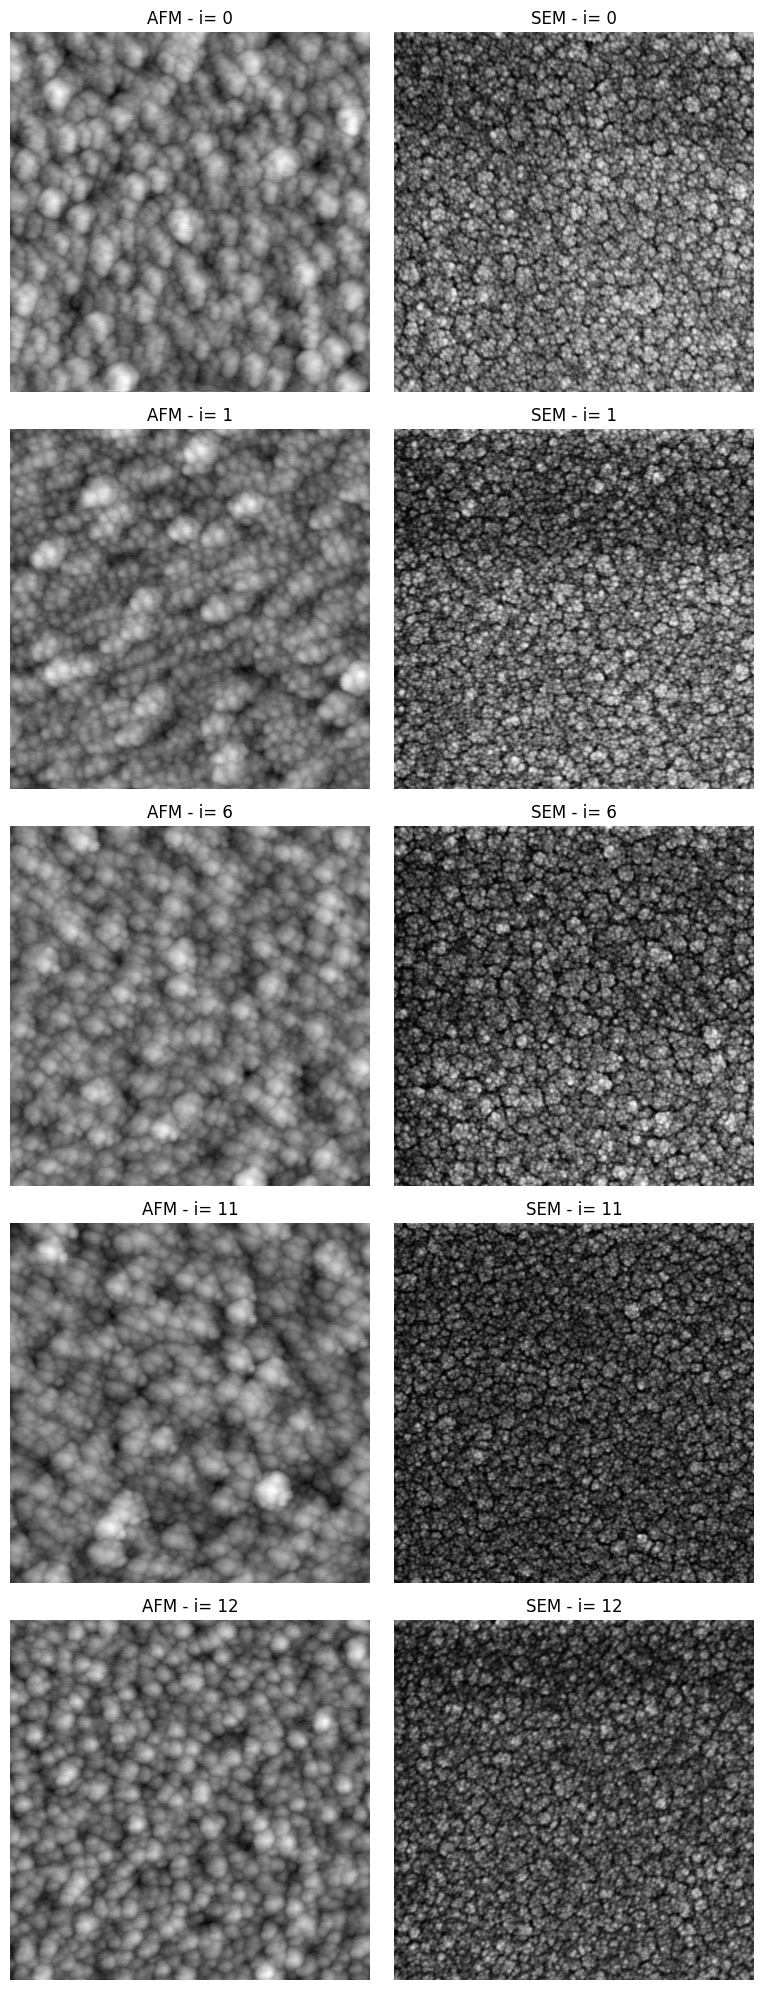

In [7]:
import matplotlib.pyplot as plt

# Get the total number of instances
num_total_instances = len(reordered_afm_array)

# Select indices for beginning, middle, and end
# Ensure indices are within bounds
selected_indices = []

# Beginning
if num_total_instances > 0: selected_indices.append(0)
if num_total_instances > 1: selected_indices.append(1)

# Middle
if num_total_instances > 2:
    middle_index = num_total_instances // 2
    if middle_index not in selected_indices: selected_indices.append(middle_index)

# End
if num_total_instances > 0:
    last_index = num_total_instances - 1
    if last_index not in selected_indices: selected_indices.append(last_index)
if num_total_instances > 1:
    second_last_index = num_total_instances - 2
    if second_last_index not in selected_indices: selected_indices.append(second_last_index)

# Sort and remove duplicates in case the array is very small and indices overlap
selected_indices = sorted(list(set(selected_indices)))

num_to_display = len(selected_indices)

if num_to_display == 0:
    print("No instances to display.")
else:
    fig, axes = plt.subplots(num_to_display, 2, figsize=(8, num_to_display * 4))
    if num_to_display == 1: # Handle case of single row subplot for consistency
        axes = np.array([axes])

    for i, idx in enumerate(selected_indices):
        afm_img = np.asarray(reordered_afm_array[idx], dtype=float)
        sem_img = np.asarray(reordered_cropped_sem_array[idx], dtype=float)

        axes[i, 0].imshow(afm_img, cmap="gray")
        axes[i, 0].set_title(f"AFM - i= {idx}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(sem_img, cmap="gray")
        axes[i, 1].set_title(f"SEM - i= {idx}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


We specify the length per pixel based on prior known knowledge about the dataset

In [9]:
CONFIG = {
    "afm_scan_um": 1.0,
    "afm_px": 512,
    "nm_per_px": 1000.0 / 512.0,   # 1.953125
    "rolling_window": 4,
    "weights": {"roughness": 0.35, "sharpness_gradient": 0.35, "psd_metric": 0.30},
    "score_bins": [0.2, 0.4, 0.6, 0.8],
    "score_labels": ["New/Excellent", "Good", "Moderate Wear", "Significant Wear", "Broken/Replace"],
}
CONFIG


{'afm_scan_um': 1.0,
 'afm_px': 512,
 'nm_per_px': 1.953125,
 'rolling_window': 4,
 'weights': {'roughness': 0.35, 'sharpness_gradient': 0.35, 'psd_metric': 0.3},
 'score_bins': [0.2, 0.4, 0.6, 0.8],
 'score_labels': ['New/Excellent',
  'Good',
  'Moderate Wear',
  'Significant Wear',
  'Broken/Replace']}

## Utility Functions

The following helper functions implement normalization, image quality metrics, and scoring logic used in IQ-X. All functions are defined once to ensure a clear, top-to-bottom execution flow.


## Image-quality metrics and scoring (IQ-X core)

### Metrics (per image)
- **Roughness (global variability):** standard deviation of pixel intensities/height values.  
  *Note:* this is a global image statistic and can reflect sample morphology, not only imaging quality.
- **Gradient sharpness:** mean magnitude of the image gradient; lower values typically indicate **blurring** (loss of edge detail).
- **PSD metric:** a frequency-domain descriptor derived from the radial power spectral density (FFT); captures dominant spatial-frequency structure beyond the DC component.

### Scoring
Each metric is min–max normalized across the dataset and then combined into a single score using fixed weights:

- Score range: **0 (best) → 1 (worst)**  
- The “condition” label is a **coarse binning of the score** for interpretability. It should be treated as an image-quality tier (not ground-truth tip condition) unless independent tip ground truth is available.


In [10]:
# Helper functions

def _as_2d_float(img):
    img = np.asarray(img, dtype=np.float64)
    if img.ndim != 2:
        raise ValueError(f"Expected 2D image, got shape {img.shape}")
    if not np.isfinite(img).all():
        img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
    return img

def afm_rms_roughness(img):
    img = _as_2d_float(img)
    return float(np.std(img))

def afm_gradient_sharpness(img):
    img = _as_2d_float(img)
    gy, gx = np.gradient(img)
    return float(np.mean(np.sqrt(gx**2 + gy**2)))

def afm_psd_metric(img, dc_skip=5):
    img = _as_2d_float(img)
    F = fft2(img - np.mean(img))
    psd = np.abs(fftshift(F))**2

    y, x = np.indices(psd.shape)
    cy = (y.max() - y.min()) / 2.0
    cx = (x.max() - x.min()) / 2.0
    r = np.hypot(x - cx, y - cy).astype(np.int32)

    radial = np.bincount(r.ravel(), psd.ravel()) / np.maximum(np.bincount(r.ravel()), 1)
    if radial.size > (dc_skip + 1):
        return float(radial[np.argmax(radial[dc_skip:]) + dc_skip])
    return 0.0

def compute_metrics(images):
    rows = []
    for im in images:
        rows.append({
            "roughness": afm_rms_roughness(im),
            "sharpness_gradient": afm_gradient_sharpness(im),
            "psd_metric": afm_psd_metric(im),
        })
    return pd.DataFrame(rows)

def normalize_degradation_df(df, cols=("roughness","sharpness_gradient","psd_metric")):
    # NOTE: Your current assumption is "metric decreases when degradation increases" so you invert.
    out = df.copy()
    for col in cols:
        mn, mx = float(df[col].min()), float(df[col].max())
        out[col] = 0.0 if mx == mn else 1.0 - (df[col] - mn) / (mx - mn)
    return out

def degradation_score(df_norm, weights):
    score = np.zeros(len(df_norm), dtype=float)
    wsum = 0.0
    for k, w in weights.items():
        if k in df_norm.columns:
            score += df_norm[k].to_numpy(dtype=float) * float(w)
            wsum += float(w)
    return score / wsum if wsum > 0 else score

def classify_tip_condition(scores, bins, labels):
    out = []
    for s in scores:
        if s < bins[0]: out.append(labels[0])
        elif s < bins[1]: out.append(labels[1])
        elif s < bins[2]: out.append(labels[2])
        elif s < bins[3]: out.append(labels[3])
        else: out.append(labels[4])
    return out


In [13]:
df_metrics_afm = compute_metrics([np.asarray(im, float) for im in reordered_afm_array])
df_norm_afm = normalize_degradation_df(df_metrics_afm)
scores_afm = degradation_score(df_norm_afm, CONFIG["weights"])
cond_afm = classify_tip_condition(scores_afm, CONFIG["score_bins"], CONFIG["score_labels"])

df_afm = df_metrics_afm.copy()
df_afm["score"] = scores_afm
# df_afm["condition"] = cond_afm
df_afm


,roughness,sharpness_gradient,psd_metric,score
0,2.141431e-09,3.524175e-10,7.993692e-10,0.590043
1,1.832350e-09,3.268205e-10,6.079971e-10,0.762079
2,1.646444e-09,2.961875e-10,6.699571e-10,0.866764
3,2.267985e-09,3.353711e-10,1.015098e-09,0.556215
4,2.860630e-09,3.954229e-10,1.789332e-09,0.124596
5,2.770527e-09,4.502769e-10,1.231168e-09,0.127969
6,2.254633e-09,3.760816e-10,7.622358e-10,0.514804
7,1.958981e-09,3.519091e-10,5.379453e-10,0.686434
8,1.663784e-09,3.651951e-10,1.989728e-10,0.794500
9,1.470077e-09,2.981856e-10,2.445781e-10,0.986859


In [12]:
df_metrics_sem = compute_metrics([np.asarray(im, float) for im in reordered_cropped_sem_array])
df_norm_sem = normalize_degradation_df(df_metrics_sem)
scores_sem = degradation_score(df_norm_sem, CONFIG["weights"])

df_sem = df_metrics_sem.copy()
df_sem["score"] = scores_sem
df_sem


,roughness,sharpness_gradient,psd_metric,score
0,51.711120,26.317698,1.316174e+13,0.484783
1,55.403376,29.006525,1.268289e+13,0.355909
2,50.526402,26.505594,1.061232e+13,0.536558
3,38.783667,19.460151,7.041157e+12,0.976100
4,53.491796,24.990646,1.576117e+13,0.443960
5,44.366802,20.426755,1.557441e+13,0.734967
6,49.885228,22.207977,1.693619e+13,0.564604
7,53.280827,35.560577,2.109444e+13,0.160279
8,52.138202,27.173119,1.059533e+13,0.488693
9,52.361277,26.987194,3.066059e+13,0.245500


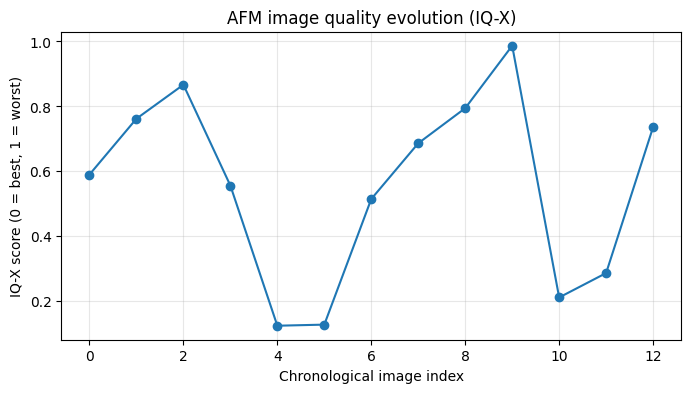

In [14]:
plt.figure(figsize=(8,4))
plt.plot(df_afm.index, df_afm["score"], marker="o")
plt.xlabel("Chronological image index")
plt.ylabel("IQ-X score (0 = best, 1 = worst)")
plt.title("AFM image quality evolution (IQ-X)")
plt.grid(alpha=0.3)
plt.show()


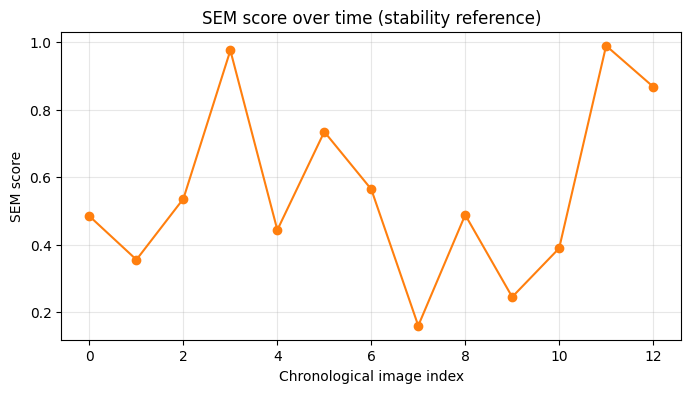

In [15]:
plt.figure(figsize=(8,4))
plt.plot(df_sem.index, df_sem["score"], marker="o", color="tab:orange")
plt.xlabel("Chronological image index")
plt.ylabel("SEM score")
plt.title("SEM score over time (stability reference)")
plt.grid(alpha=0.3)
plt.show()


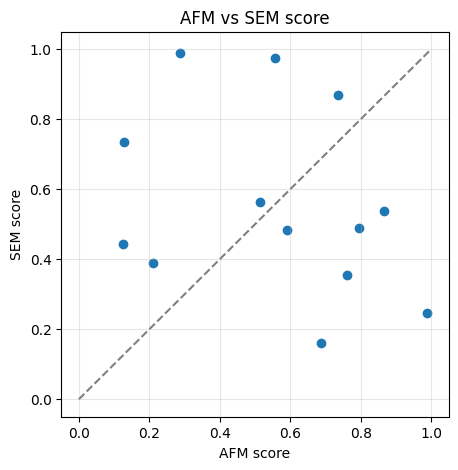

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(df_afm["score"], df_sem["score"])
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("AFM score")
plt.ylabel("SEM score")
plt.title("AFM vs SEM score")
plt.grid(alpha=0.3)
plt.show()


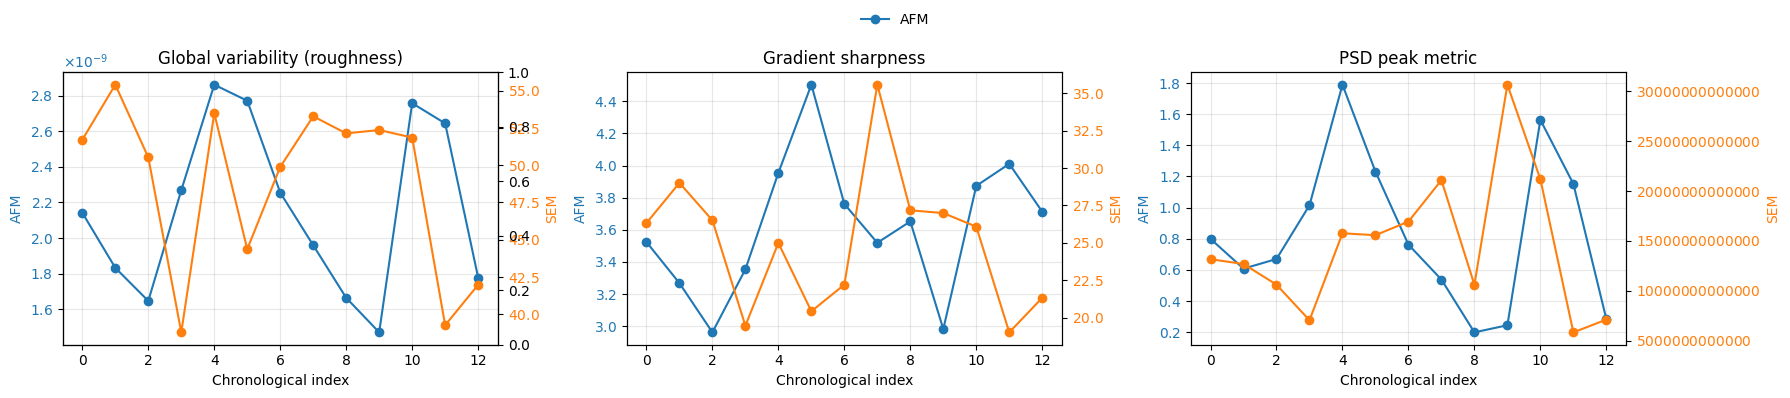

In [27]:
metrics = ["roughness", "sharpness_gradient", "psd_metric"]
pretty = {
    "roughness": "Global variability (roughness)",
    "sharpness_gradient": "Gradient sharpness",
    "psd_metric": "PSD peak metric"
}

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

for ax, m in zip(axes, metrics):
    ax2 = ax.twinx()

    ax.plot(df_afm.index, df_afm[m],
            marker="o", color="tab:blue", label="AFM")
    ax2.plot(df_sem.index, df_sem[m],
             marker="o", color="tab:orange", label="SEM")

    ax.set_title(pretty[m])
    ax.set_xlabel("Chronological index")
    ax.set_ylabel("AFM", color="tab:blue")
    ax2.set_ylabel("SEM", color="tab:orange")

    # Fix AFM axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.yaxis.get_offset_text().set_visible(False)

    # Fix SEM axis
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.ticklabel_format(axis='y', style='plain')

    ax.tick_params(axis="y", labelcolor="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    ax.grid(alpha=0.3)

# One shared legend for the whole figure
lines1, labels1 = axes[0].get_legend_handles_labels()
lines2, labels2 = axes[0].twinx().get_legend_handles_labels()

fig.legend(lines1 + lines2, labels1 + labels2,
           loc="upper center", ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


## Degradation metric (standardized deviation from SEM)

We define AFM image degradation as the **standardized deviation** of AFM metrics from their *paired* SEM reference, computed per image.

For each metric \(m\) and image \(i\), we compute a standardized residual

\[
r_{i,m} = \frac{\Delta_{i,m}}{\sigma^{SEM}_{m} + \epsilon},
\]

where \(\sigma^{SEM}_{m}\) is the standard deviation of the SEM metric across the dataset (used as a scale factor), and \(\epsilon\) is a small constant to avoid division by zero.

### Sign convention
Residuals are defined so that larger values correspond to **worse AFM image quality**:

- **Gradient sharpness:** since sharper images have larger gradient magnitude, degradation (blur) reduces sharpness. We therefore use  
\[
\Delta_{i,\text{sharp}} = x^{SEM}_{i,\text{sharp}} - x^{AFM}_{i,\text{sharp}}.
\]

- **Roughness** and **PSD peak metric:** these descriptors can be influenced by morphology and/or contrast, and their direction of change is not guaranteed across datasets. To avoid imposing an incorrect sign, we use an unsigned deviation:  
\[
\Delta_{i,m} = \left|x^{AFM}_{i,m} - x^{SEM}_{i,m}\right|.
\]

Finally, we aggregate residuals into a single degradation score using a weighted RMS:

\[
D_i = \sqrt{\sum_m w_m\, r_{i,m}^2}.
\]

This score is **relative and dimensionless**: it measures how strongly AFM deviates from its SEM reference in units of SEM variability.


In [33]:
# --- Option A: Standardized deviation from SEM (per paired image) ---
# Requires: df_metrics_afm, df_metrics_sem, CONFIG["weights"]
# Output: df_afm["deg_semA"]  (dimensionless degradation score; higher = worse)

import numpy as np
import pandas as pd

# Small constant to avoid divide-by-zero
EPS = 1e-12

# Metrics to use (must exist in both dataframes)
metrics = [m for m in ["roughness", "sharpness_gradient", "psd_metric"]
           if (m in df_metrics_afm.columns) and (m in df_metrics_sem.columns)]

if len(metrics) == 0:
    raise ValueError("No common metrics found between df_metrics_afm and df_metrics_sem.")

# SEM scale (variability) per metric
sem_sigma = df_metrics_sem[metrics].std(ddof=1).replace(0, np.nan)

# Sign / delta definitions:
# - sharpness_gradient: positive means AFM is worse (AFM sharpness lower than SEM)
# - roughness, psd_metric: unsigned deviation (no assumed direction)
delta = pd.DataFrame(index=df_metrics_afm.index)

for m in metrics:
    if m == "sharpness_gradient":
        delta[m] = (df_metrics_sem[m] - df_metrics_afm[m])  # positive => AFM blur/worse
    else:
        delta[m] = (df_metrics_afm[m] - df_metrics_sem[m]).abs()  # magnitude-only

# Standardized residuals r_{i,m}
r = delta.divide(sem_sigma + EPS)

# Weights: use your CONFIG weights, but only for metrics present
w = {k: float(v) for k, v in CONFIG["weights"].items() if k in metrics}
wsum = sum(w.values())
if wsum <= 0:
    raise ValueError("CONFIG['weights'] has no positive weights for the available metrics.")

# Weighted RMS aggregation: D_i = sqrt( sum_m w_m r_{i,m}^2 )
deg = np.zeros(len(r), dtype=float)
for m, wm in w.items():
    deg += wm * (r[m].to_numpy(dtype=float) ** 2)

deg = np.sqrt(deg)

# Attach outputs
df_afm = df_metrics_afm.copy()  # if you prefer keep your existing df_afm, remove this line
df_afm["deg_semA"] = deg
df_afm


,roughness,sharpness_gradient,psd_metric,deg_semA
0,2.141431e-09,3.524175e-10,7.993692e-10,6.448619
1,1.832350e-09,3.268205e-10,6.079971e-10,6.948155
2,1.646444e-09,2.961875e-10,6.699571e-10,6.329825
3,2.267985e-09,3.353711e-10,1.015098e-09,4.786531
4,2.860630e-09,3.954229e-10,1.789332e-09,6.552190
5,2.770527e-09,4.502769e-10,1.231168e-09,5.456302
6,2.254633e-09,3.760816e-10,7.622358e-10,6.077682
7,1.958981e-09,3.519091e-10,5.379453e-10,7.393324
8,1.663784e-09,3.651951e-10,1.989728e-10,6.515600
9,1.470077e-09,2.981856e-10,2.445781e-10,6.905314


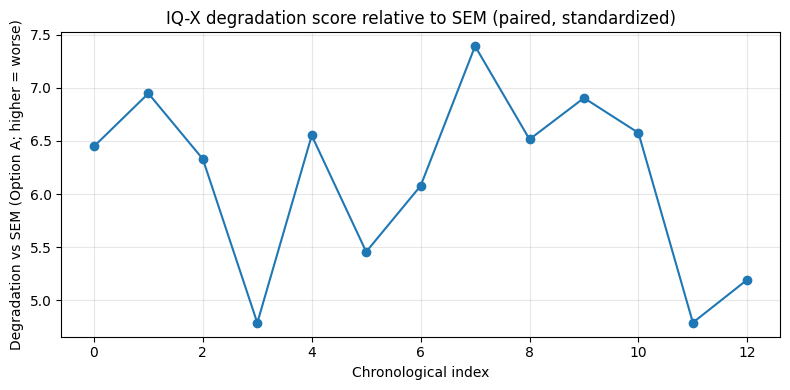

In [34]:
# --- Plot: degradation vs time (Option A) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df_afm.index, df_afm["deg_semA"], marker="o")
plt.xlabel("Chronological index")
plt.ylabel("Degradation vs SEM (Option A; higher = worse)")
plt.title("IQ-X degradation score relative to SEM (paired, standardized)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## PCA on AFM–SEM residuals

To explore whether multiple degradation mechanisms are present, we apply PCA to the standardized AFM–SEM residuals. PCA is used here strictly as a diagnostic tool to identify dominant modes of deviation from the SEM reference and to interpret which image descriptors contribute most strongly to degradation. The principal component scores are examined as a function of acquisition order, while component loadings are used to relate each mode to specific image metrics.


In [36]:
from sklearn.decomposition import PCA

X = r.to_numpy()  # shape: (n_images, n_metrics)


In [37]:
pca = PCA()
Z = pca.fit_transform(X)


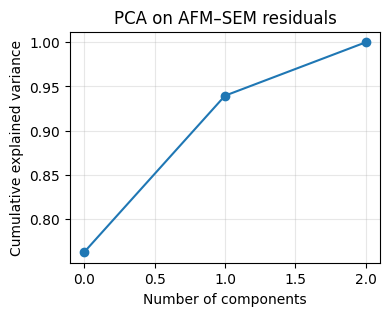

array([0.76244317, 0.17708173, 0.0604751 ])

In [38]:
evr = pca.explained_variance_ratio_

plt.figure(figsize=(4,3))
plt.plot(np.cumsum(evr), marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA on AFM–SEM residuals")
plt.grid(alpha=0.3)
plt.show()

evr


## Dimensionality of degradation

The cumulative explained variance shows that the **first principal component (PC1)** captures the majority of variance in the AFM–SEM residuals, with PC1 and PC2 together explaining nearly all variability. This indicates that AFM image degradation relative to SEM is **low-dimensional**, dominated by one primary mechanism with a weaker secondary contribution.


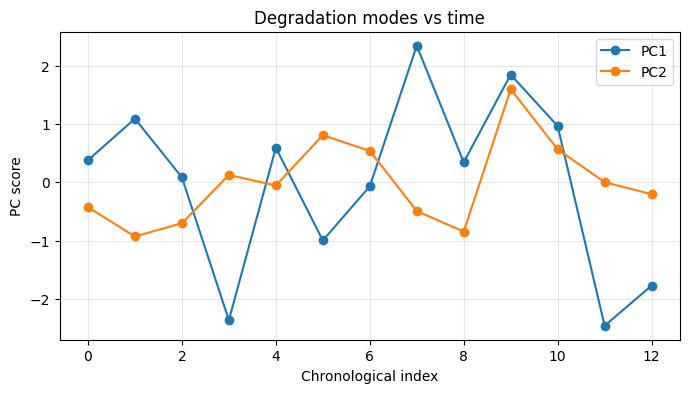

In [39]:
plt.figure(figsize=(8,4))
plt.plot(Z[:,0], marker="o", label="PC1")
if Z.shape[1] > 1:
    plt.plot(Z[:,1], marker="o", label="PC2")

plt.xlabel("Chronological index")
plt.ylabel("PC score")
plt.title("Degradation modes vs time")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Temporal evolution of degradation modes

The principal component scores reveal how each degradation mode evolves with acquisition order. PC1 exhibits large, structured variations over time, indicating a systematic degradation process rather than random fluctuations. PC2 shows smaller-amplitude, non-monotonic behavior, suggesting a secondary effect that modulates but does not dominate the overall degradation trend.


In [40]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=r.columns,
    columns=[f"PC{i+1}" for i in range(r.shape[1])]
)

loadings


,PC1,PC2,PC3
roughness,0.614575,-0.257361,0.745696
sharpness_gradient,0.592937,-0.472780,-0.651847
psd_metric,0.520311,0.842760,-0.137960


## Interpretation of PCA loadings

The PCA loadings indicate how individual image descriptors contribute to each degradation mode:

- **PC1** has comparable positive contributions from roughness, gradient sharpness, and PSD-based descriptors, indicating a **global AFM–SEM deviation mode** in which multiple aspects of image quality degrade coherently.
- **PC2** is dominated by the PSD-based descriptor, with roughness and sharpness contributing in opposition, suggesting a **frequency-specific or texture-related effect** that is partially decoupled from overall blur.

This separation supports the interpretation of PC1 as the dominant AFM image degradation mode.


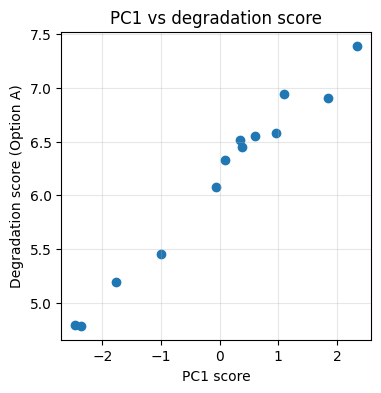

In [41]:
plt.figure(figsize=(4,4))
plt.scatter(Z[:,0], df_afm["deg_semA"])
plt.xlabel("PC1 score")
plt.ylabel("Degradation score (Option A)")
plt.title("PC1 vs degradation score")
plt.grid(alpha=0.3)
plt.show()


## Relation between PCA and degradation score

The strong monotonic relationship between PC1 scores and the proposed degradation metric indicates that the scalar degradation score effectively captures the **dominant PCA mode**. In other words, the degradation score corresponds closely to the primary direction of AFM deviation from SEM identified by PCA.


# Artifact-Aware AFM Image Quality Metrics

This notebook computes interpretable image descriptors from AFM images and converts them into **artifact-aware scores** for:
- **Blur / loss of fine detail**
- **Double-tip (ghosting)**
- **Feedback / scan-line artifacts**

We also compute the same descriptors on SEM reference images (optional) to evaluate **metric stability** and guide calibration.


In [42]:
import numpy as np

# Optional dependency
try:
    import pandas as pd
except Exception:
    pd = None

import matplotlib.pyplot as plt


## Preprocessing and numerical safety

All images are treated as 2D arrays and converted to `float64`.  
A robust normalization step (MAD normalization after percentile clipping) is applied to reduce sensitivity to brightness/contrast scaling and outliers.


In [43]:
def _to_float2d(img):
    x = np.asarray(img)
    if x.ndim != 2:
        raise ValueError(f"Expected 2D image, got shape={x.shape}")
    return x.astype(np.float64, copy=False)

def _robust_normalize(img, clip_p=(1, 99), eps=1e-12):
    x = _to_float2d(img).copy()
    lo, hi = np.percentile(x, clip_p)
    if hi - lo < eps:
        return x * 0.0
    x = np.clip(x, lo, hi)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + eps
    return (x - med) / mad

def _hann2d(h, w):
    return np.outer(np.hanning(h), np.hanning(w))

def _fft2_power(img):
    x = _to_float2d(img)
    win = _hann2d(*x.shape)
    F = np.fft.fft2(x * win)
    return np.abs(np.fft.fftshift(F)) ** 2

def _radial_mask(h, w, r_min, r_max=None):
    cy, cx = h // 2, w // 2
    yy, xx = np.ogrid[:h, :w]
    rr = np.sqrt((yy - cy) ** 2 + (xx - cx) ** 2)
    m = rr >= r_min
    if r_max is not None:
        m &= rr <= r_max
    return m, rr

def _safe_div(a, b, eps=1e-12):
    return float(a) / float(b + eps)


## Autocorrelation for spatial structure

We use the 2D autocorrelation function (ACF) to capture repeated patterns and spatial periodicity.
- **Correlation length** increases when images are smoothed/blurred.
- **Side-peaks** in the ACF can indicate duplicated structure consistent with **double-tip** artifacts.


In [44]:
def autocorr2d(img):
    x = _to_float2d(img)
    x = x - np.mean(x)
    F = np.fft.fft2(x)
    ac = np.fft.ifft2(np.abs(F) ** 2).real
    ac = np.fft.fftshift(ac)
    peak = ac.max()
    return ac / peak if peak > 0 else ac * 0.0

def estimate_corr_length(ac, frac=0.5):
    h, w = ac.shape
    cy, cx = h // 2, w // 2
    yy, xx = np.ogrid[:h, :w]
    rr = np.sqrt((yy - cy) ** 2 + (xx - cx) ** 2).astype(int)

    max_r = rr.max()
    prof = np.zeros(max_r + 1)
    cnt = np.zeros(max_r + 1)

    np.add.at(prof, rr.ravel(), ac.ravel())
    np.add.at(cnt, rr.ravel(), 1)

    prof /= np.maximum(cnt, 1)
    for r in range(1, len(prof)):
        if prof[r] <= frac:
            return float(r)
    return np.nan


## Artifact-aware metric definitions

### Blur / loss of detail
Computed from:
- High-frequency power ratio in the FFT (`hf_ratio`)
- Gradient energy (`grad_energy`)
- Laplacian energy (`lap_energy`)
- Autocorrelation-based correlation length (`corr_length`)

### Double-tip / ghosting
Computed from:
- Strongest off-center side-peak in the autocorrelation (`sidepeak_strength`)
- Distance of the side-peak from center (`sidepeak_r`)
- Side-peak orientation (`sidepeak_angle`)

### Feedback / scan-line artifacts
Computed from:
- Power concentrated along Fourier axes (`axis_power_ratio`)
- Narrowband peak prominence in PSD (`narrowband_peak_prom`)
- Variation in line-wise mean intensity (`line_mean_std`)


In [45]:
def blur_metrics(img):
    x = _to_float2d(img)
    h, w = x.shape
    P = _fft2_power(x)

    dc_r = max(2, int(0.02 * min(h, w)))
    total_mask, _ = _radial_mask(h, w, dc_r)
    hf_mask, _ = _radial_mask(h, w, int(0.25 * min(h, w)))

    hf_ratio = _safe_div(P[hf_mask].sum(), P[total_mask].sum())

    gy, gx = np.gradient(x)
    grad_energy = np.mean(np.sqrt(gx**2 + gy**2))

    lap = (np.roll(x,1,0)+np.roll(x,-1,0)+np.roll(x,1,1)+np.roll(x,-1,1)-4*x)
    lap_energy = np.mean(np.abs(lap))

    ac = autocorr2d(x)
    corr_length = estimate_corr_length(ac)

    return dict(
        hf_ratio=hf_ratio,
        grad_energy=grad_energy,
        lap_energy=lap_energy,
        corr_length=corr_length
    )

def double_tip_metrics(img, inner_exclude=5, search_r_min=6):
    ac = autocorr2d(img)
    h, w = ac.shape
    cy, cx = h // 2, w // 2

    mask, rr = _radial_mask(h, w, inner_exclude)
    mask &= rr >= search_r_min

    if not mask.any():
        return dict(sidepeak_strength=np.nan,
                    sidepeak_r=np.nan,
                    sidepeak_angle=np.nan)

    idx = np.argmax(ac[mask])
    ys, xs = np.where(mask)
    py, px = ys[idx], xs[idx]

    dy, dx = py - cy, px - cx
    return dict(
        sidepeak_strength=float(ac[py, px]),
        sidepeak_r=float(np.sqrt(dy**2 + dx**2)),
        sidepeak_angle=float(np.arctan2(dy, dx))
    )

def feedback_metrics(img, dc_r=3, axis_band=3):
    x = _to_float2d(img)
    h, w = x.shape

    line_mean_std = float(np.std(np.mean(x, axis=1)))
    P = _fft2_power(x)

    total_mask, _ = _radial_mask(h, w, dc_r)
    total_power = float(P[total_mask].sum())

    cy, cx = h // 2, w // 2
    axis_mask = np.zeros_like(P, dtype=bool)
    axis_mask[:, cx-axis_band:cx+axis_band+1] = True
    axis_mask[cy-axis_band:cy+axis_band+1, :] = True
    axis_mask[cy-dc_r:cy+dc_r+1, cx-dc_r:cx+dc_r+1] = False

    axis_power_ratio = _safe_div(P[axis_mask].sum(), total_power)

    bg = P[total_mask]
    narrowband_peak_prom = float(bg.max() / (np.median(bg) + 1e-12))

    return dict(
        axis_power_ratio=axis_power_ratio,
        narrowband_peak_prom=narrowband_peak_prom,
        line_mean_std=line_mean_std
    )


## Converting metrics into artifact scores

Each artifact score is computed by mapping raw metrics into a common [0, 1] scale using a saturating transform:

- Values below a lower bound map toward 0
- Values above an upper bound map toward 1

This makes scores comparable across metrics without requiring dataset-specific normalization.

**Note:** These bounds are heuristic and may be adjusted for new datasets.


In [46]:
def _sat(x, lo, hi):
    if not np.isfinite(x):
        return 0.0
    return float(np.clip((x - lo) / (hi - lo + 1e-12), 0, 1))

def compute_scores(m):
    # Blur: worse = lower HF ratio, lower gradient, lower laplacian, higher corr length
    blur = (
        (1 - _sat(m["hf_ratio"], 0.15, 0.35)) +
        (1 - _sat(m["grad_energy"], 0.8, 2.0)) +
        (1 - _sat(m["lap_energy"], 0.6, 1.5)) +
        _sat(m["corr_length"], 6, 18)
    ) / 4

    # Double tip: worse = stronger side peak + larger separation
    double_tip = (
        _sat(m["sidepeak_strength"], 0.10, 0.35) +
        _sat(m["sidepeak_r"], 6, 30)
    ) / 2

    # Feedback: worse = power on axes + strong narrowband + strong line mean variation
    feedback = (
        _sat(m["axis_power_ratio"], 0.12, 0.30) +
        _sat(m["narrowband_peak_prom"], 3, 12) +
        _sat(m["line_mean_std"], 0.15, 0.60)
    ) / 3

    return dict(
        blur_score=float(blur),
        double_tip_score=float(double_tip),
        feedback_score=float(feedback)
    )

def label_from_scores(s, thresh=0.55):
    best = max(s, key=s.get)
    return best.replace("_score","") if s[best] >= thresh else "ok/unclear"


## Per-image analysis wrapper

For each image we:
1. Apply robust normalization (percentile clip + MAD scale)
2. Compute artifact-aware metrics (blur, double-tip, feedback)
3. Convert metrics to three scores in [0, 1]
4. Optionally assign a dominant artifact label (for quick inspection)


In [48]:
def analyze_afm_images(images, ids=None):
    if ids is None:
        ids = list(range(len(images)))

    rows = []
    for img, idx in zip(images, ids):
        x = _robust_normalize(img)

        m = {"id": idx}
        m.update(blur_metrics(x))
        m.update(double_tip_metrics(x))
        m.update(feedback_metrics(x))

        scores = compute_scores(m)
        m.update(scores)
        m["label"] = label_from_scores(scores)

        rows.append(m)

    if pd is None:
        return rows
    return pd.DataFrame(rows)

# Run on chronologically ordered AFM images
afm_images = [np.asarray(im, dtype=float) for im in reordered_afm_array]
df_afm = analyze_afm_images(afm_images)

df_afm[["id", "blur_score", "double_tip_score", "feedback_score", "label"]]


,id,blur_score,double_tip_score,feedback_score,label
0,0,0.854167,0.500000,0.666667,blur
1,1,0.854167,0.500000,0.666667,blur
2,2,0.875000,0.500000,0.666667,blur
3,3,0.895833,0.500000,0.666667,blur
4,4,0.916667,0.500000,0.666667,blur
5,5,0.854167,0.500000,0.666667,blur
6,6,0.854167,0.500000,0.666667,blur
7,7,0.854167,0.508398,0.666667,blur
8,8,0.791667,0.500000,0.666667,blur
9,9,0.812500,0.508398,0.666667,blur


In [49]:
df_afm[[
    "hf_ratio",
    "grad_energy",
    "lap_energy",
    "corr_length",
    "sidepeak_strength",
    "sidepeak_r",
    "axis_power_ratio",
    "narrowband_peak_prom",
    "line_mean_std"
]]


,hf_ratio,grad_energy,lap_energy,corr_length,sidepeak_strength,sidepeak_r,axis_power_ratio,narrowband_peak_prom,line_mean_std
0,0.008279,0.242332,0.294459,11.0,0.815503,6.000000,0.483268,2.807176e+06,0.009897
1,0.010667,0.273135,0.346775,11.0,0.771383,6.000000,0.364446,2.206341e+06,0.014541
2,0.011927,0.267819,0.340281,12.0,0.802456,6.000000,0.452930,3.667469e+06,0.010243
3,0.009239,0.225481,0.279364,13.0,0.813755,6.000000,0.472696,6.323869e+06,0.015533
4,0.005708,0.204288,0.214243,14.0,0.848740,6.000000,0.419311,1.000761e+07,0.011776
5,0.005773,0.236262,0.246248,11.0,0.816092,6.000000,0.418391,5.513849e+06,0.010677
6,0.007184,0.248334,0.279474,11.0,0.774917,6.000000,0.531812,3.084291e+06,0.013056
7,0.007648,0.269898,0.307396,11.0,0.773072,6.403124,0.372217,4.440171e+06,0.012820
8,0.006243,0.319778,0.327600,8.0,0.640600,6.000000,0.353808,1.073729e+06,0.007724
9,0.009703,0.299413,0.367949,9.0,0.735754,6.403124,0.351272,1.864395e+06,0.015981


## (Optional) SEM-based stability check

If SEM images are available as paired references, we can compute the same metrics on SEM.
This is **not required** for scoring AFM, but it helps evaluate which metrics are stable in SEM and therefore less likely to be driven by sample contrast or acquisition drift.

We summarize SEM stability using the coefficient of variation (CV = std / |mean|).


In [51]:
sem_images = [np.asarray(im, dtype=float) for im in reordered_cropped_sem_array]
df_sem = analyze_afm_images(sem_images)

metrics = [
    "hf_ratio",
    "grad_energy",
    "lap_energy",
    "corr_length",
    "sidepeak_strength",
    "sidepeak_r",
    "axis_power_ratio",
    "narrowband_peak_prom",
    "line_mean_std"
]

sem_stats = {}
for m in metrics:
    x = df_sem[m].values.astype(float)
    mu = np.nanmean(x)
    sigma = np.nanstd(x)
    sem_stats[m] = {"mean": float(mu), "std": float(sigma), "cv": float(sigma / (abs(mu) + 1e-12))}

df_sem_stats = pd.DataFrame(sem_stats).T.sort_values("cv") if pd is not None else sem_stats
df_sem_stats


,mean,std,cv
sidepeak_r,6.006366,0.022054,0.003672
grad_energy,0.708830,0.066347,0.093601
sidepeak_strength,0.596470,0.058522,0.098113
lap_energy,2.759040,0.273790,0.099234
hf_ratio,0.515665,0.085227,0.165276
axis_power_ratio,0.120913,0.020837,0.172328
line_mean_std,0.284976,0.081041,0.284377
corr_length,9.153846,2.769231,0.302521
narrowband_peak_prom,27851.058078,13833.239421,0.496686


##  Metric trends with confidence bands

To visualize temporal trends while reducing noise, we plot a rolling mean with a local ±1σ band.
This is purely descriptive (not used as a decision threshold).


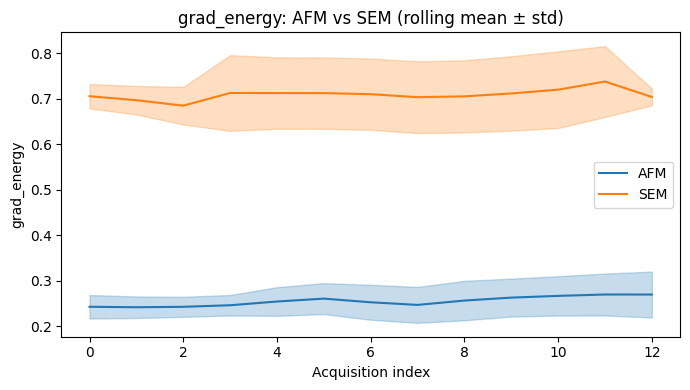

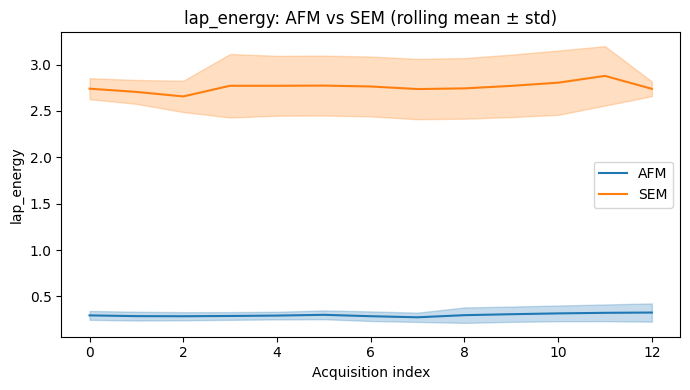

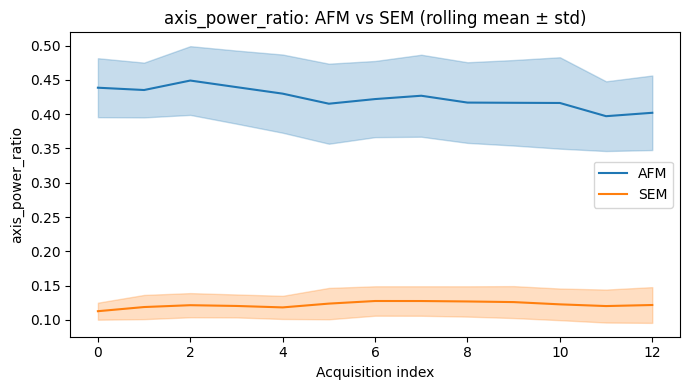

In [52]:
def rolling_mean_std(x, window=4):
    x = np.asarray(x, dtype=float)
    mean = np.full_like(x, np.nan)
    std = np.full_like(x, np.nan)
    for i in range(len(x)):
        lo = max(0, i - window)
        hi = min(len(x), i + window + 1)
        chunk = x[lo:hi]
        mean[i] = np.nanmean(chunk)
        std[i] = np.nanstd(chunk)
    return mean, std

def plot_metric_with_confidence(metric, window=4):
    afm_x = df_afm[metric].values.astype(float)
    sem_x = df_sem[metric].values.astype(float)
    t = np.arange(len(afm_x))

    afm_mean, afm_std = rolling_mean_std(afm_x, window)
    sem_mean, sem_std = rolling_mean_std(sem_x, window)

    plt.figure(figsize=(7,4))
    plt.plot(t, afm_mean, label="AFM", color="C0")
    plt.fill_between(t, afm_mean - afm_std, afm_mean + afm_std, color="C0", alpha=0.25)

    plt.plot(t, sem_mean, label="SEM", color="C1")
    plt.fill_between(t, sem_mean - sem_std, sem_mean + sem_std, color="C1", alpha=0.25)

    plt.xlabel("Acquisition index")
    plt.ylabel(metric)
    plt.title(f"{metric}: AFM vs SEM (rolling mean ± std)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot a few key metrics (edit list as needed)
for m in ["grad_energy", "lap_energy", "axis_power_ratio"]:
    if m in df_afm.columns:
        plot_metric_with_confidence(m)


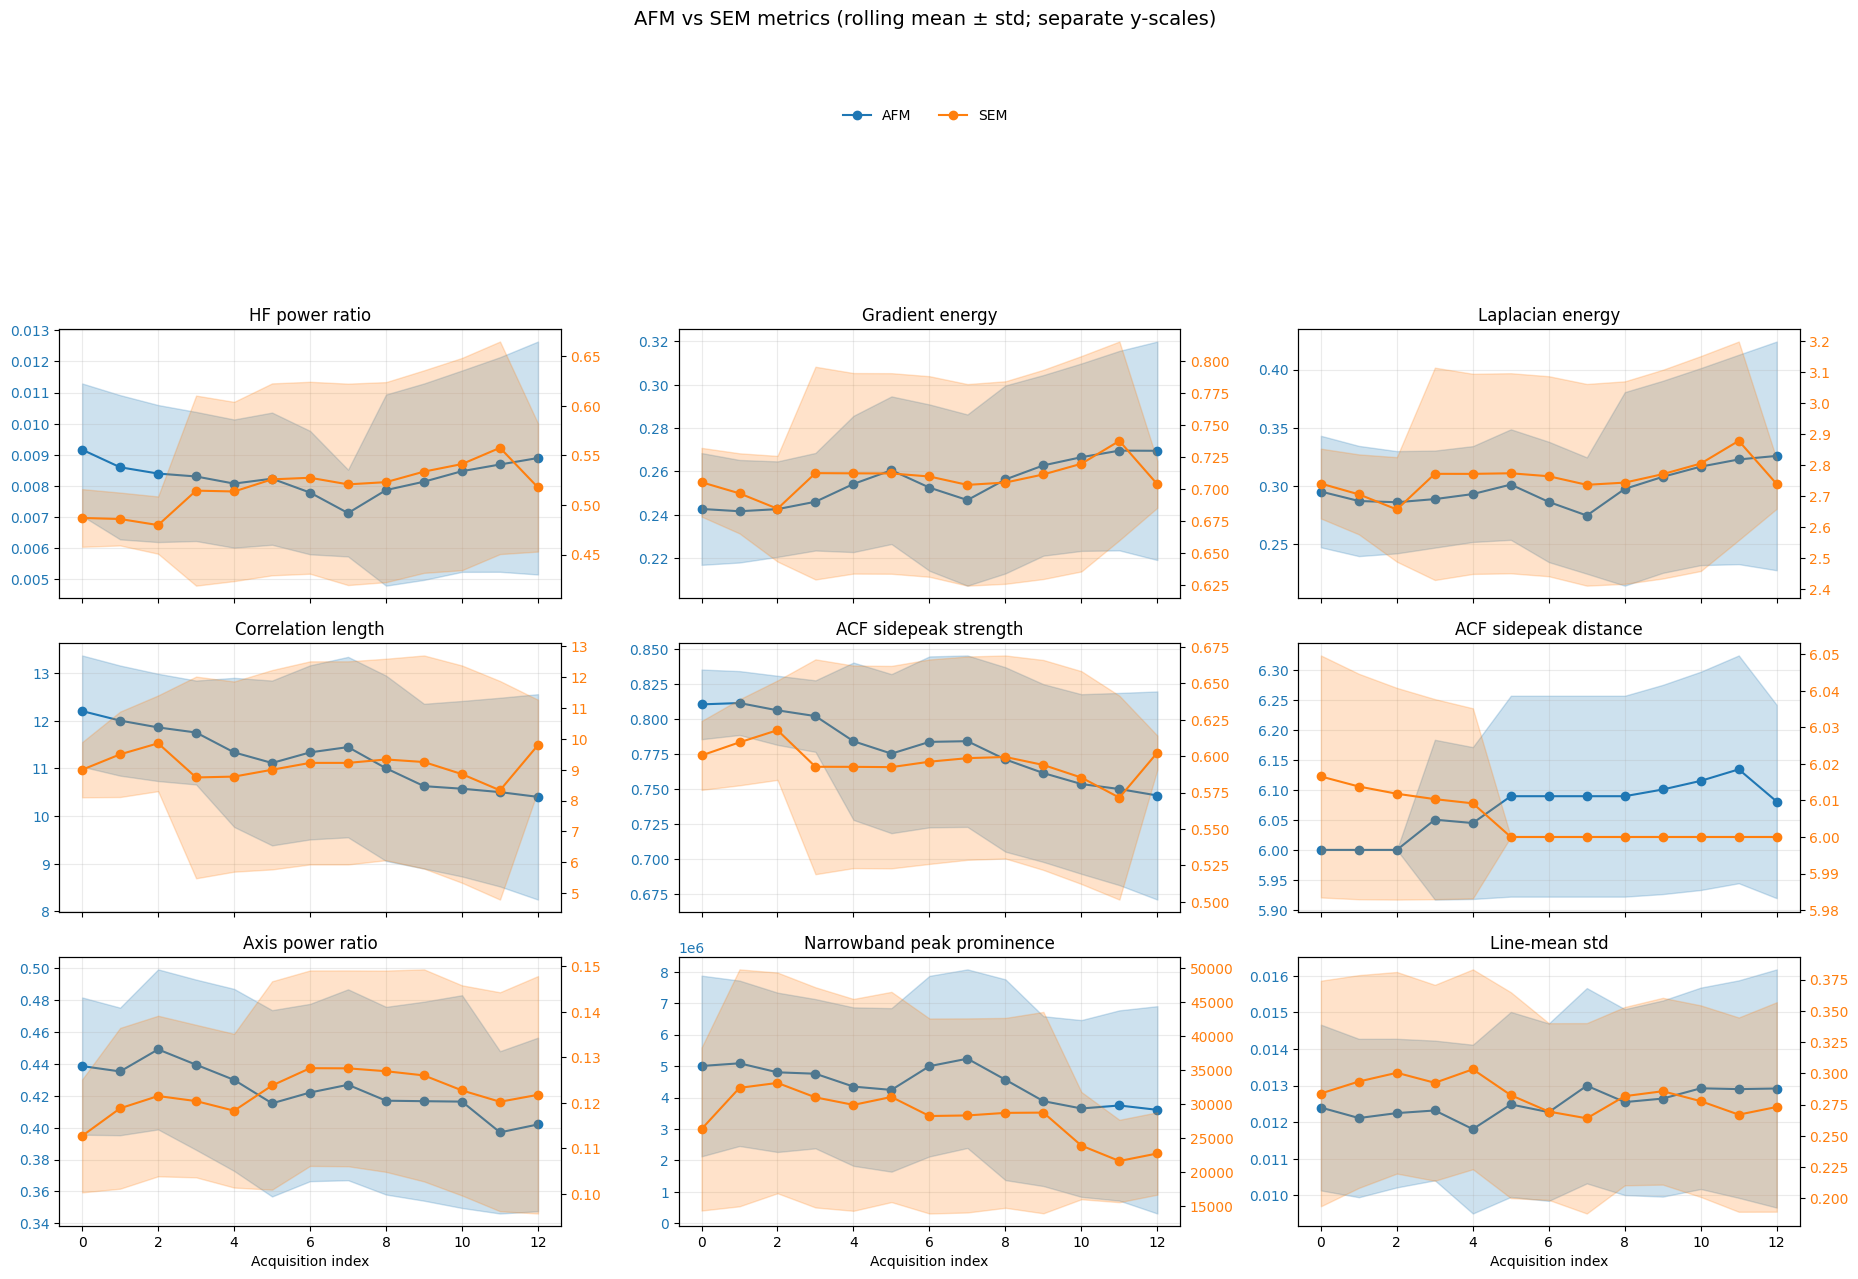

In [56]:
# --- Dual-axis (AFM vs SEM) rolling mean ± std for ALL metrics in a grid ---

import numpy as np
import matplotlib.pyplot as plt

# Metrics to plot (must exist in both df_afm and df_sem)
metrics = [
    "hf_ratio",
    "grad_energy",
    "lap_energy",
    "corr_length",
    "sidepeak_strength",
    "sidepeak_r",
    "axis_power_ratio",
    "narrowband_peak_prom",
    "line_mean_std",
]
metrics = [m for m in metrics if (m in df_afm.columns) and (m in df_sem.columns)]

pretty = {
    "hf_ratio": "HF power ratio",
    "grad_energy": "Gradient energy",
    "lap_energy": "Laplacian energy",
    "corr_length": "Correlation length",
    "sidepeak_strength": "ACF sidepeak strength",
    "sidepeak_r": "ACF sidepeak distance",
    "axis_power_ratio": "Axis power ratio",
    "narrowband_peak_prom": "Narrowband peak prominence",
    "line_mean_std": "Line-mean std",
}

def rolling_mean_std(x, window=4):
    x = np.asarray(x, dtype=float)
    mean = np.full_like(x, np.nan)
    std = np.full_like(x, np.nan)
    for i in range(len(x)):
        lo = max(0, i - window)
        hi = min(len(x), i + window + 1)
        chunk = x[lo:hi]
        mean[i] = np.nanmean(chunk)
        std[i] = np.nanstd(chunk)
    return mean, std

def plot_metrics_with_confidence_dual_grid(df_afm, df_sem, metrics, window=4, ncols=3):
    n = len(metrics)
    nrows = int(np.ceil(n / ncols))
    t = np.arange(len(df_afm))

    fig, axes = plt.subplots(nrows, ncols, figsize=(6.2*ncols, 3.6*nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    ax2_list = []

    for k, m in enumerate(metrics):
        ax = axes[k]
        ax2 = ax.twinx()
        ax2_list.append(ax2)

        afm_x = df_afm[m].values.astype(float)
        sem_x = df_sem[m].values.astype(float)

        afm_mean, afm_std = rolling_mean_std(afm_x, window)
        sem_mean, sem_std = rolling_mean_std(sem_x, window)

        # AFM (left axis)
        ax.plot(t, afm_mean, color="C0", marker="o", linewidth=1.5, label="AFM")
        ax.fill_between(t, afm_mean - afm_std, afm_mean + afm_std, color="C0", alpha=0.22)

        # SEM (right axis)
        ax2.plot(t, sem_mean, color="C1", marker="o", linewidth=1.5, label="SEM")
        ax2.fill_between(t, sem_mean - sem_std, sem_mean + sem_std, color="C1", alpha=0.22)

        ax.set_title(pretty.get(m, m))
        ax.grid(alpha=0.25)
        ax.tick_params(axis="y", labelcolor="C0")
        ax2.tick_params(axis="y", labelcolor="C1")

        if (k // ncols) == (nrows - 1):
            ax.set_xlabel("Acquisition index")

        # Keep y-labels minimal to avoid clutter; uncomment if you want them:
        # ax.set_ylabel("AFM", color="C0")
        # ax2.set_ylabel("SEM", color="C1")

    # Turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # One shared legend (use proxy handles)
    # One shared legend (use proxy handles)
    afm_proxy = plt.Line2D([0], [0], color="C0", marker="o",
                           linewidth=1.5, label="AFM")
    sem_proxy = plt.Line2D([0], [0], color="C1", marker="o",
                           linewidth=1.5, label="SEM")

    fig.legend(
        handles=[afm_proxy, sem_proxy],
        loc="upper center",
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, 1.10)   # ← move legend ABOVE title
    )

    fig.suptitle(
        "AFM vs SEM metrics (rolling mean ± std; separate y-scales)",
        y=1.18, fontsize=14          # ← push title higher
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Run it
plot_metrics_with_confidence_dual_grid(df_afm, df_sem, metrics, window=4, ncols=3)



Each panel compares the temporal evolution of a specific image descriptor for AFM (blue, left axis) and SEM (orange, right axis), shown as a rolling mean with ±1σ bands. AFM and SEM are plotted on separate y-axes to preserve their native dynamic ranges; interpretation is based on **relative temporal behavior**, not absolute magnitude.

**Blur / resolution-sensitive metrics** (HF power ratio, gradient energy, Laplacian energy, correlation length) show coherent trends in AFM while remaining comparatively stable in SEM. In particular, AFM gradient and Laplacian energies evolve together, and the AFM correlation length decreases over time, consistent with changes in effective spatial resolution or convolution rather than random noise. The stability of the corresponding SEM metrics indicates that these trends are not driven by sample morphology or contrast changes.

**Double-tip indicators** (ACF sidepeak strength and sidepeak distance) remain nearly constant for both AFM and SEM. The absence of increasing sidepeak strength or changing sidepeak separation suggests that ghosting or double-tip artifacts are not a dominant or evolving degradation mechanism in this dataset.

**Feedback and scan-line indicators** (axis power ratio, narrowband peak prominence, line-mean standard deviation) also remain largely stable, with no systematic growth in AFM relative to SEM. This indicates that feedback instabilities or scan-direction artifacts are unlikely to be the primary source of image degradation.

Overall, the figure shows that AFM-specific changes are concentrated in blur-related descriptors, while metrics associated with double-tip and feedback artifacts remain stable. This supports the conclusion that AFM image quality variations in this dataset are dominated by changes in effective resolution rather than ghosting or feedback failure.
